# Project: Implementing and Evaluating Adversarial Attacks (MNIST)

## Part 1: Baseline Model and FGSM Attack

This notebook demonstrates how to:
1. Train a baseline Convolutional Neural Network (CNN) for MNIST digit classification.
2. Apply the Fast Gradient Sign Method (FGSM) adversarial attack using the Adversarial Robustness Toolbox (ART).
3. Evaluate the model's performance degradation under attack.

We are using Python with TensorFlow/Keras and the ART library.

**Author:** Chaudry Abdullah and Shahmir Ahmed
**Roll** 2022-CS-206 and 2022_CS-215

---

### Step 1: Setup Environment & Imports

This step involves ensuring the necessary libraries are installed (run `pip install tensorflow numpy matplotlib adversarial-robustness-toolbox[keras]` in your environment's terminal if needed) and importing them into the notebook.

In [3]:
# Core libraries
import numpy as np
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt # For visualization later

# Keras components
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# ART components
from art.estimators.classification import KerasClassifier # we didnt use this as it conflicted with the eager running mode
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier

# Check TensorFlow version (optional but good practice)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}") # Checks for GPU
# Check if Keras is running eagerly
print(f"Keras is eagerly running: {tf.executing_eagerly()}")

g:\semester 6\IS\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
g:\semester 6\IS\project\.venv\Lib\site-packages\art\estimators\certification\__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


TensorFlow Version: 2.19.0
Num GPUs Available: 0
Keras is eagerly running: True


### Step 2: Load and Preprocess MNIST Data

Load the MNIST dataset using Keras utilities. Preprocess the images by:
- Reshaping to include the channel dimension (28x28x1).
- Converting to float32 data type.
- Normalizing pixel values to the [0, 1] range.
Preprocess the labels by converting them to one-hot encoded vectors.

In [4]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# --- Preprocess images ---
# Reshape and add channel dimension
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Convert data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize pixel values
x_train /= 255.0
x_test /= 255.0

# --- Preprocess labels ---
num_classes = 10
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes) # Keep original y_test for later checks

print("--- MNIST Data Loaded and Preprocessed ---")
print(f"x_train shape: {x_train.shape}")
print(f"y_train_categorical shape: {y_train_categorical.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test_categorical shape: {y_test_categorical.shape}")
print(f"Input shape for model: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Min/Max pixel values: {x_train.min()}/{x_train.max()}") # Verify normalization

--- MNIST Data Loaded and Preprocessed ---
x_train shape: (60000, 28, 28, 1)
y_train_categorical shape: (60000, 10)
x_test shape: (10000, 28, 28, 1)
y_test_categorical shape: (10000, 10)
Input shape for model: (28, 28, 1)
Number of classes: 10
Min/Max pixel values: 0.0/1.0


### Step 3: Build and Train Baseline CNN Model

Define a simple CNN architecture. Compile it with appropriate loss function (`categorical_crossentropy`) and optimizer (`Adam`). Train the model on the clean training data and evaluate its initial performance on the clean test data. Finally, save the trained model's architecture and weights for later use and reproducibility.

*Note: If a trained model file (`mnist_cnn_baseline.keras`) already exists, this step can optionally load it instead of retraining.*

In [5]:
import os # To check for existing model file

model_file_path = 'mnist_cnn_baseline.keras' # Use the new Keras format

# --- Option 1: Train a new model if file doesn't exist ---
if not os.path.exists(model_file_path):
    print(f"Model file '{model_file_path}' not found. Training a new model...")

    # Build the CNN model
    model = Sequential(name="Baseline_MNIST_CNN") # Give the model a name
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Print model summary
    model.summary()

    # Training parameters
    batch_size = 128
    epochs = 5 # Keep epochs low for quick testing, can increase

    # Train the model
    print("\n--- Training the baseline model ---")
    history = model.fit(x_train, y_train_categorical,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.1)

    # Save the entire model (architecture + weights + optimizer state)
    print(f"\nSaving trained model to {model_file_path}")
    model.save(model_file_path)
    print("Model saved.")

else:
    # --- Option 2: Load existing model ---
    print(f"Found existing model file '{model_file_path}'. Loading model...")
    model = load_model(model_file_path)
    print("Model loaded successfully.")
    model.summary() # Display summary of loaded model


# --- Evaluate the baseline model on the CLEAN test set ---
print("\n--- Evaluating baseline model on clean test data ---")
score = model.evaluate(x_test, y_test_categorical, verbose=0)
baseline_accuracy = score[1] # Store for later comparison
print(f"Clean Test Loss: {score[0]:.4f}")
print(f"Clean Test Accuracy: {baseline_accuracy:.4f}")

Found existing model file 'mnist_cnn_baseline.keras'. Loading model...
Model loaded successfully.


Model: "Baseline_MNIST_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,480 (408.13 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,654 (272.09 KB)


--- Evaluating baseline model on clean test data ---
Clean Test Loss: 0.0379
Clean Test Accuracy: 0.9876


### Step 4: Prepare for Attack with ART

Wrap the loaded/trained Keras model using ART's `TensorFlowV2Classifier`. This wrapper standardizes the interface for ART attacks. We must provide:
- The Keras model object.
- `clip_values`: The valid range of input data (0.0 to 1.0 for our normalized MNIST).
- `use_logits`: Set to `False` because our model's output layer uses `softmax` (outputs probabilities).

In [6]:
    # Cell 8 (Code - Wrap Model with ART - Corrected)

    # Data range for clip_values
    min_pixel_value = 0.0
    max_pixel_value = 1.0

    # --- Create an instance of the loss function object ---
    # We need the actual callable object, not just the string name
    loss_fn = CategoricalCrossentropy()

    # --- Instantiate TensorFlowV2Classifier ---
    classifier = TensorFlowV2Classifier(
        model=model,
        nb_classes=num_classes,
        input_shape=input_shape,
        loss_object=loss_fn,  # <<< CHANGE HERE: Pass the loss object instance
        clip_values=(min_pixel_value, max_pixel_value),
        channels_first=False
    )

    print("--- Keras model wrapped with ART TensorFlowV2Classifier ---")

--- Keras model wrapped with ART TensorFlowV2Classifier ---


### Step 5: Configure and Create the FGSM Attack

Instantiate the `FastGradientMethod` attack object from ART. Key parameters:
- `estimator`: The ART-wrapped classifier.
- `eps`: Epsilon, controlling the maximum perturbation amount (attack strength). We'll start with 0.1.
- `targeted`: Set to `False` for untargeted attacks (aiming for *any* misclassification).

In [7]:
# FGSM parameters
epsilon = 0.1  # Perturbation budget - EXPERIMENT with this value later! (e.g., 0.05, 0.2)

print(f"--- Configuring Fast Gradient Sign Method (FGSM) attack ---")
print(f"Epsilon (eps): {epsilon}")

# Create the FGSM attack instance
attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps=epsilon,
    targeted=False
)

print("FGSM attack object created successfully.")

--- Configuring Fast Gradient Sign Method (FGSM) attack ---
Epsilon (eps): 0.1
FGSM attack object created successfully.


### Step 6: Generate Adversarial Examples

Now we use the configured FGSM attack object (`attack_fgsm`) to generate adversarial samples from our clean test dataset (`x_test`). The `.generate()` method takes the original images as input and outputs the perturbed images.
The method calculates the gradients and applies the FGSM formula (original_image + epsilon * sign(gradient)) for each image in x_test.

In [8]:
# Generate adversarial examples using the test set
print("--- Generating adversarial examples using FGSM ---")
print(f"Using epsilon = {epsilon}") # Display epsilon used for clarity

# Generate adversarial test examples
# It's often good practice to generate on a subset for quicker testing,
# but here we'll use the whole test set for a complete evaluation.
x_test_adv = attack_fgsm.generate(x=x_test)

print("Adversarial examples generated.")
print(f"Shape of adversarial test set: {x_test_adv.shape}")

--- Generating adversarial examples using FGSM ---
Using epsilon = 0.1
Adversarial examples generated.
Shape of adversarial test set: (10000, 28, 28, 1)


### Step 7: Evaluate Model on Adversarial Examples

We evaluate the performance of the *original baseline model* on the adversarial test set (`x_test_adv`) generated in the previous step. We compare the accuracy on these perturbed images to the `baseline_accuracy` obtained on the clean test data. A significant drop in accuracy indicates the success of the attack.

In [9]:
# Evaluate the baseline model on the ADVERSARIAL test set
print("\n--- Evaluating baseline model on ADVERSARIAL test data ---")

# Use the original Keras model's evaluate method
score_adv = model.evaluate(x_test_adv, y_test_categorical, verbose=0)
adversarial_accuracy = score_adv[1]

print(f"Adversarial Test Loss: {score_adv[0]:.4f}")
print(f"Adversarial Test Accuracy: {adversarial_accuracy:.4f}")

# Compare with baseline accuracy
print("\n--- Comparison ---")
print(f"Clean Test Accuracy (Baseline): {baseline_accuracy:.4f}")
print(f"Adversarial Test Accuracy (FGSM, eps={epsilon}): {adversarial_accuracy:.4f}")
accuracy_drop = baseline_accuracy - adversarial_accuracy
print(f"Accuracy Drop due to attack: {accuracy_drop:.4f}")


--- Evaluating baseline model on ADVERSARIAL test data ---
Adversarial Test Loss: 0.3082
Adversarial Test Accuracy: 0.8875

--- Comparison ---
Clean Test Accuracy (Baseline): 0.9876
Adversarial Test Accuracy (FGSM, eps=0.1): 0.8875
Accuracy Drop due to attack: 0.1001


### Step 8: Visualize Results

To better understand the effect of the FGSM attack, let's visualize a few examples. We will display:
- The original clean test image.
- The model's prediction on the clean image.
- The adversarial image generated by FGSM.
- The model's (likely incorrect) prediction on the adversarial image.
- The perturbation (noise) added by the attack (amplified for visibility).

We'll focus on examples where the attack successfully fooled the model.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Displaying 5 examples of FGSM attack (eps=0.1) ---


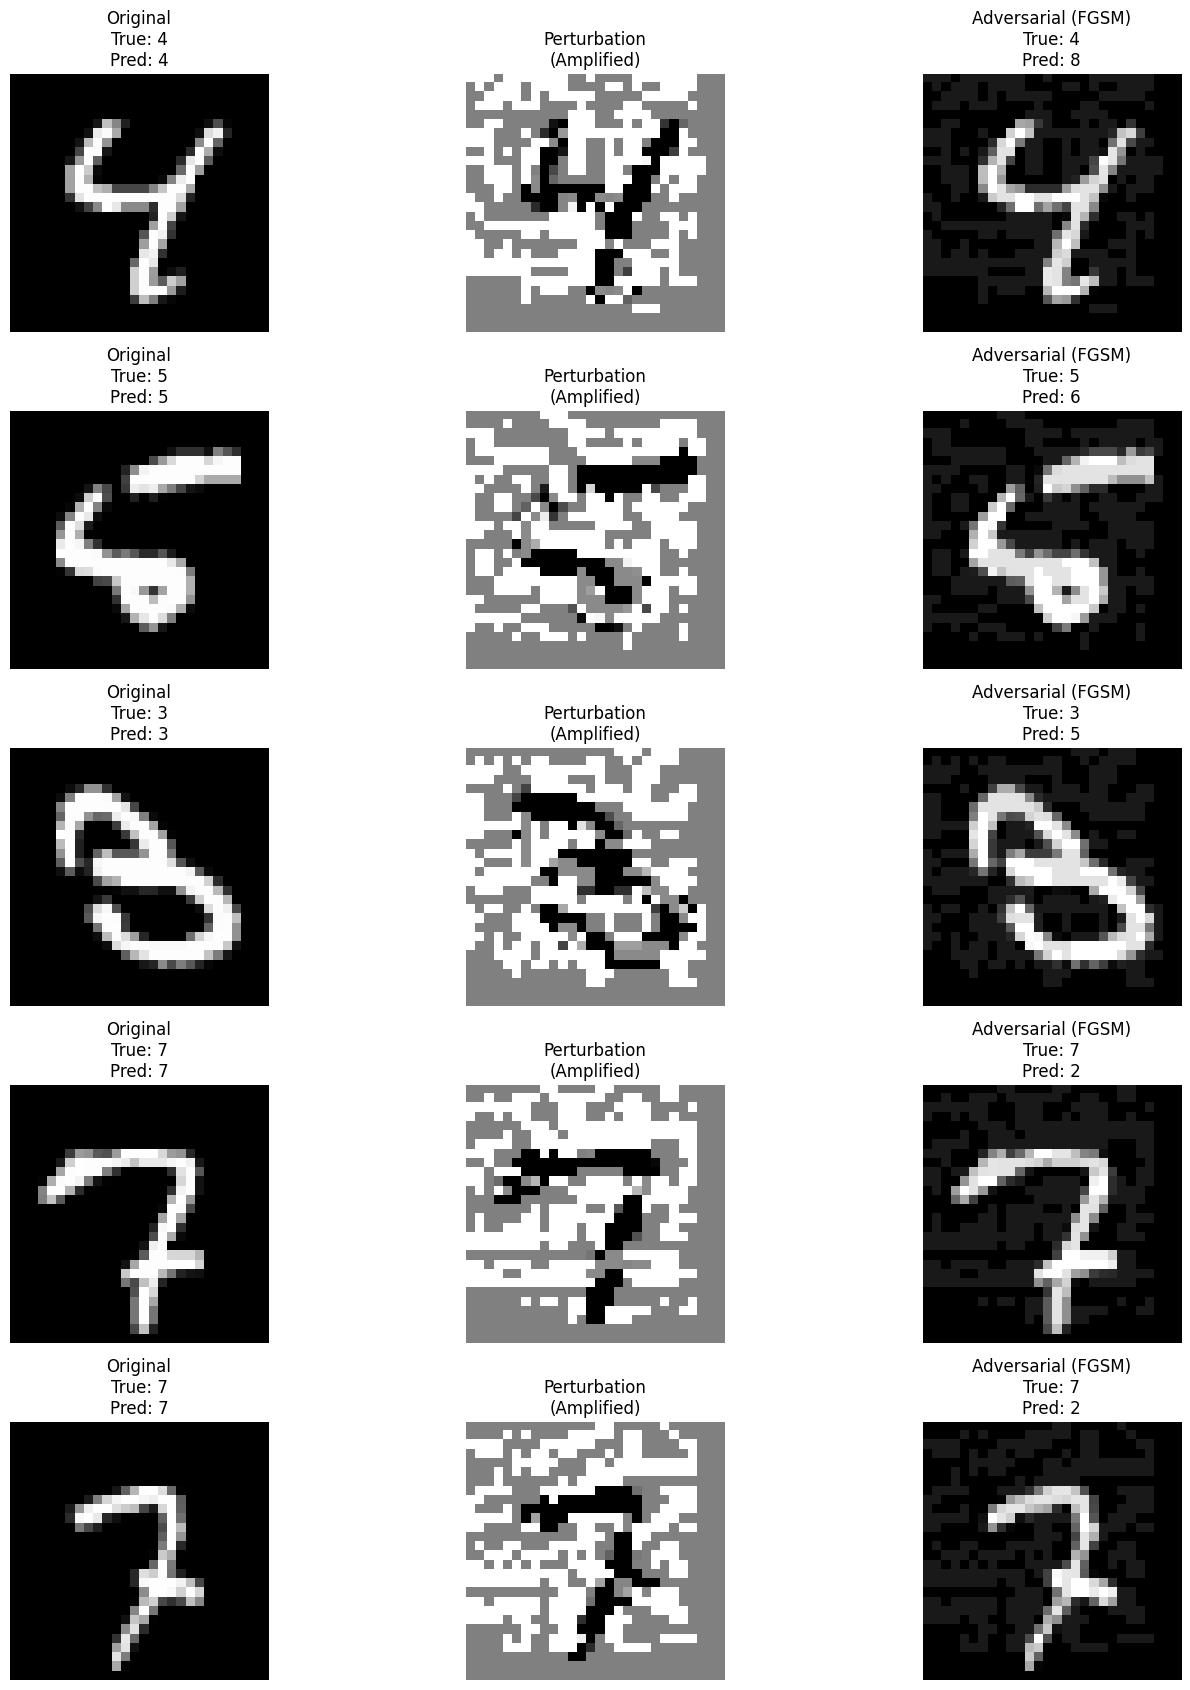

In [10]:
# --- Visualization ---
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions for both clean and adversarial images
# Use the original Keras model for predictions
preds_clean = model.predict(x_test)
preds_adv = model.predict(x_test_adv)

# Convert one-hot encoded labels and predictions to integers
labels_clean_int = np.argmax(y_test_categorical, axis=1)
preds_clean_int = np.argmax(preds_clean, axis=1)
preds_adv_int = np.argmax(preds_adv, axis=1)

# Find indices where the attack was successful
# i.e., model was correct on clean image, but wrong on adversarial image
successful_attack_indices = np.where((preds_clean_int == labels_clean_int) &
                                     (preds_adv_int != labels_clean_int))[0]

# Select a few examples to display
num_examples_to_show = 5
if len(successful_attack_indices) < num_examples_to_show:
    print(f"Warning: Found only {len(successful_attack_indices)} successful attacks.")
    # If few successes, maybe show some where original was correct, regardless of adv pred
    print("Showing examples where original prediction was correct.")
    display_indices = np.where(preds_clean_int == labels_clean_int)[0][:num_examples_to_show]
else:
     display_indices = successful_attack_indices[:num_examples_to_show]


print(f"\n--- Displaying {len(display_indices)} examples of FGSM attack (eps={epsilon}) ---")

plt.figure(figsize=(15, 2 + 3 * len(display_indices))) # Adjust figure size

for i, index in enumerate(display_indices):
    # Original image
    plt.subplot(len(display_indices), 3, i * 3 + 1)
    # Reshape to (28, 28) for imshow if needed (remove channel dim)
    plt.imshow(x_test[index].squeeze(), cmap='gray')
    plt.title(f"Original\nTrue: {labels_clean_int[index]}\nPred: {preds_clean_int[index]}")
    plt.axis('off')

    # Perturbation (amplified for visibility)
    # Ensure perturbation is calculated correctly and clipped if necessary for visualization
    perturbation = x_test_adv[index] - x_test[index]
    # Scale perturbation for display: map range roughly to [0,1]
    pert_min = np.min(perturbation)
    pert_max = np.max(perturbation)
    if pert_max - pert_min > 1e-5: # Avoid division by zero
         perturbation_viz = (perturbation - pert_min) / (pert_max - pert_min)
    else:
         perturbation_viz = perturbation # If no difference, show as is

    plt.subplot(len(display_indices), 3, i * 3 + 2)
    plt.imshow(perturbation_viz.squeeze(), cmap='gray')
    plt.title(f"Perturbation\n(Amplified)")
    plt.axis('off')


    # Adversarial image
    plt.subplot(len(display_indices), 3, i * 3 + 3)
    plt.imshow(x_test_adv[index].squeeze(), cmap='gray')
    plt.title(f"Adversarial (FGSM)\nTrue: {labels_clean_int[index]}\nPred: {preds_adv_int[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

---
# Part 2: Defense Against Evasion Attacks - Adversarial Training
---

In Part 1, we demonstrated that our baseline CNN model is vulnerable to FGSM evasion attacks. Now, we will implement a common defense technique: **Adversarial Training**.

The core idea is to retrain the model using a dataset that includes both original clean images and adversarial examples generated from those clean images. This exposure during training helps the model learn features that are more robust to the specific type of perturbations introduced by the attack.

### Step 9: Generate Adversarial Training Data

First, we need to create adversarial versions of our *training* data (`x_train`) using the same FGSM attack configuration (`attack_fgsm`, `epsilon=0.1`) we used against the test set.

In [11]:
# --- Generate adversarial examples for the TRAINING set ---
print("--- Generating adversarial examples for the TRAINING set using FGSM ---")
print(f"Using epsilon = {epsilon}") # Re-state the epsilon being used

# Generate adversarial training examples
# Note: This can take significantly longer than generating for the test set
# because the training set is larger (60,000 images vs 10,000).
# Consider generating on a subset for faster experimentation if needed:
# subset_size = 10000
# x_train_adv = attack_fgsm.generate(x=x_train[:subset_size])
# But for a proper defense evaluation, using the full set is better if time permits.

x_train_adv = attack_fgsm.generate(x=x_train)

print("Adversarial training examples generated.")
print(f"Shape of adversarial training set: {x_train_adv.shape}")

# Optional: Check a sample perturbation on training data
# perturbation_train_sample = x_train_adv[0] - x_train[0]
# print(f"Perturbation range on a training sample: min={np.min(perturbation_train_sample):.4f}, max={np.max(perturbation_train_sample):.4f}")

--- Generating adversarial examples for the TRAINING set using FGSM ---
Using epsilon = 0.1
Adversarial training examples generated.
Shape of adversarial training set: (60000, 28, 28, 1)


### Step 10: Create Augmented Training Dataset

Combine the original clean training images (`x_train`) with the newly generated adversarial training images (`x_train_adv`). The corresponding labels remain the same (since FGSM doesn't change the true class, just fools the model). We then shuffle this augmented dataset to ensure the model sees clean and adversarial examples in a mixed order during training.

In [12]:
# --- Combine clean and adversarial training data ---

# Stack the clean and adversarial training images
x_train_augmented = np.vstack((x_train, x_train_adv))

# Stack the corresponding labels (they are the same for clean and adversarial versions)
# y_train_categorical contains the one-hot encoded labels from Step 2
# If you used a subset for x_train_adv, make sure to use the corresponding subset of labels here.
y_train_augmented = np.vstack((y_train_categorical, y_train_categorical))

# Shuffle the augmented dataset
# It's crucial to shuffle so the model doesn't see all clean then all adversarial samples
num_augmented_samples = x_train_augmented.shape[0]
shuffle_indices = np.random.permutation(num_augmented_samples)

x_train_augmented = x_train_augmented[shuffle_indices]
y_train_augmented = y_train_augmented[shuffle_indices]

print("--- Augmented training dataset created ---")
print(f"Shape of augmented training images: {x_train_augmented.shape}")
print(f"Shape of augmented training labels: {y_train_augmented.shape}")

--- Augmented training dataset created ---
Shape of augmented training images: (120000, 28, 28, 1)
Shape of augmented training labels: (120000, 10)


### Step 11: Define and Train the Defended Model

We now define a *new* CNN model with the **exact same architecture** as our baseline model. It's important to start from scratch (uninitialized weights) rather than continuing to train the baseline model. We then train this new model using the augmented dataset (`x_train_augmented`, `y_train_augmented`) created in the previous step.

This process exposes the model to both clean and adversarial examples during its learning phase, encouraging it to develop representations that are less sensitive to the FGSM perturbations.

In [13]:
from tensorflow.keras.models import Sequential # Already imported, but good to be clear
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Ditto
from tensorflow.keras.optimizers import Adam # Ditto

# --- Define the NEW model for Adversarial Training ---
# Use the same architecture as the baseline model (Step 3)

model_defended = Sequential(name="Defended_MNIST_CNN") # Give it a distinct name
model_defended.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_defended.add(MaxPooling2D(pool_size=(2, 2)))
model_defended.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_defended.add(MaxPooling2D(pool_size=(2, 2)))
model_defended.add(Flatten())
model_defended.add(Dropout(0.5))
model_defended.add(Dense(num_classes, activation='softmax'))

# --- Compile the Defended Model ---
# Use the same optimizer and loss object instance as before
# Using the loss object instance 'loss_fn' created in Step 8 is recommended
optimizer_defended = Adam(learning_rate=0.001) # Use a fresh optimizer instance
model_defended.compile(loss=loss_fn, # Use the CategoricalCrossentropy object instance
                       optimizer=optimizer_defended,
                       metrics=['accuracy'])

# Print model summary
model_defended.summary()

# --- Training parameters ---
# May need slightly more epochs or adjustment compared to baseline,
# but start with similar values.
batch_size_defended = 128
epochs_defended = 5 # Start with same epochs as baseline, may need tuning

# --- Train the Defended Model on the Augmented Data ---
print("\n--- Training the DEFENDED model on AUGMENTED data ---")
history_defended = model_defended.fit(x_train_augmented, y_train_augmented,
                                      batch_size=batch_size_defended,
                                      epochs=epochs_defended,
                                      verbose=1,
                                      validation_split=0.1) # Validate on a split of the augmented data

# --- Save the Defended Model ---
model_defended_file_path = 'mnist_cnn_defended_adv_train.keras'
print(f"\nSaving adversarially trained model to {model_defended_file_path}")
model_defended.save(model_defended_file_path)
print("Defended model saved.")

g:\semester 6\IS\project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Defended_MNIST_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the DEFENDED model on AUGMENTED data ---
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8130 - loss: 0.5976 - val_accuracy: 0.9605 - val_loss: 0.1234
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9575 - loss: 0.1317 - val_accuracy: 0.9751 - val_loss: 0.0757
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9703 - loss: 0.0899 - val_accuracy: 0.9833 - val_loss: 0.0527
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9785 - loss: 0.0656 - val_accuracy: 0.9874 - val_loss: 0.0403
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9831 - loss: 0.0525 - val_accuracy: 0.9883 - val_loss: 0.0364

Saving adversarially trained model to mnist_cnn_defended_adv_train.keras
Defended model saved.


### Step 12: Evaluate the Defended Model

Now we evaluate the performance of the adversarially trained model (`model_defended`). Crucially, we test it on two datasets:
1.  The **clean test set** (`x_test`): To see if adversarial training significantly harmed its ability to classify normal, unperturbed images. Ideally, the accuracy should remain high, though sometimes a slight drop compared to the baseline is observed.
2.  The **adversarial test set** (`x_test_adv`): This is the key test. We use the *same* adversarial examples that fooled the original baseline model. We expect the defended model to perform significantly better (higher accuracy) on these examples than the baseline model did.

In [14]:
# Optional: Load the saved defended model if needed (e.g., if you restarted the notebook)
# from tensorflow.keras.models import load_model
# model_defended_file_path = 'mnist_cnn_defended_adv_train.keras'
# if 'model_defended' not in locals(): # Check if model_defended exists in memory
#     print(f"Loading defended model from {model_defended_file_path}")
#     model_defended = load_model(model_defended_file_path)
#     print("Defended model loaded.")

# --- Evaluate Defended Model on CLEAN Test Data ---
print("\n--- Evaluating DEFENDED model on CLEAN test data ---")
score_defended_clean = model_defended.evaluate(x_test, y_test_categorical, verbose=0)
defended_accuracy_clean = score_defended_clean[1]

print(f"Defended Model - Clean Test Loss: {score_defended_clean[0]:.4f}")
print(f"Defended Model - Clean Test Accuracy: {defended_accuracy_clean:.4f}")

# --- Evaluate Defended Model on ADVERSARIAL Test Data ---
# Use the SAME x_test_adv generated in Step 6 (Cell 12)
print("\n--- Evaluating DEFENDED model on ADVERSARIAL test data (FGSM, eps={epsilon}) ---")
score_defended_adv = model_defended.evaluate(x_test_adv, y_test_categorical, verbose=0)
defended_accuracy_adv = score_defended_adv[1]

print(f"Defended Model - Adversarial Test Loss: {score_defended_adv[0]:.4f}")
print(f"Defended Model - Adversarial Test Accuracy: {defended_accuracy_adv:.4f}")


# --- Comparison Summary ---
print("\n--- Performance Comparison Summary ---")

print("\nAccuracy on CLEAN Data:")
print(f"  Baseline Model: {baseline_accuracy:.4f}")
print(f"  Defended Model: {defended_accuracy_clean:.4f}")

print("\nAccuracy on ADVERSARIAL Data (FGSM, eps={epsilon}):")
print(f"  Baseline Model: {adversarial_accuracy:.4f}") # Calculated in Step 7 (Cell 14)
print(f"  Defended Model: {defended_accuracy_adv:.4f}")

# Calculate improvement
accuracy_improvement_adv = defended_accuracy_adv - adversarial_accuracy
print(f"\nImprovement in Adversarial Accuracy due to Defense: {accuracy_improvement_adv:.4f}")


--- Evaluating DEFENDED model on CLEAN test data ---
Defended Model - Clean Test Loss: 0.0320
Defended Model - Clean Test Accuracy: 0.9897

--- Evaluating DEFENDED model on ADVERSARIAL test data (FGSM, eps={epsilon}) ---
Defended Model - Adversarial Test Loss: 0.0376
Defended Model - Adversarial Test Accuracy: 0.9874

--- Performance Comparison Summary ---

Accuracy on CLEAN Data:
  Baseline Model: 0.9876
  Defended Model: 0.9897

Accuracy on ADVERSARIAL Data (FGSM, eps={epsilon}):
  Baseline Model: 0.8875
  Defended Model: 0.9874

Improvement in Adversarial Accuracy due to Defense: 0.0999


### Step 13: Visualize Comparative Results

A bar chart provides an effective way to visualize the performance comparison between the baseline model and the adversarially trained (defended) model. We will plot the accuracy scores on both the clean test data and the adversarial test data (generated using FGSM with the specified epsilon) for both models side-by-side.

This visualization should clearly highlight:
1.  The significant drop in the baseline model's accuracy when faced with adversarial examples.
2.  The improved robustness (higher accuracy on adversarial examples) of the defended model.
3.  Any potential trade-off in accuracy on clean data for the defended model.

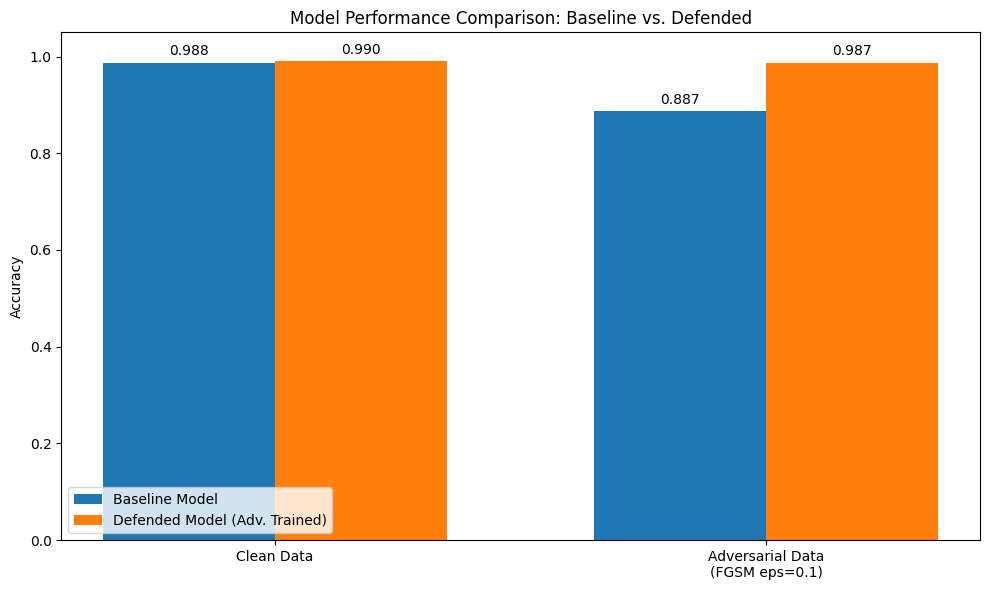

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data for Plotting ---
labels = ['Clean Data', f'Adversarial Data\n(FGSM eps={epsilon})']
baseline_performance = [baseline_accuracy, adversarial_accuracy] # From Step 3 (Cell 6) & Step 7 (Cell 14)
defended_performance = [defended_accuracy_clean, defended_accuracy_adv] # From Step 12 (Cell 24)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# --- Create Plot ---
fig, ax = plt.subplots(figsize=(10, 6)) # Increase figure size for better readability

# Plot bars for baseline model
rects1 = ax.bar(x - width/2, baseline_performance, width, label='Baseline Model', color='tab:blue')

# Plot bars for defended model
rects2 = ax.bar(x + width/2, defended_performance, width, label='Defended Model (Adv. Trained)', color='tab:orange')

# --- Add labels, title, and axes ticks ---
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison: Baseline vs. Defended')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1.05]) # Set y-axis limit slightly above 1.0
ax.legend(loc='lower left') # Position legend

# --- Add exact values on top of bars (optional but helpful) ---
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# --- Display Plot ---
fig.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [16]:
import numpy as np
import os

# Create data directory if it doesn't exist
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# Assuming x_test is your clean test numpy array (e.g., shape (10000, 28, 28, 1))
np.save(os.path.join(data_dir, 'x_test.npy'), x_test)
print(f"Saved clean test data to {os.path.join(data_dir, 'x_test.npy')}")

# Optional: Also save adversarial examples if you have x_test_adv
if 'x_test_adv' in locals():
   np.save(os.path.join(data_dir, 'x_test_adv.npy'), x_test_adv)
   print(f"Saved adversarial test data to {os.path.join(data_dir, 'x_test_adv.npy')}")

Saved clean test data to data\x_test.npy
Saved adversarial test data to data\x_test_adv.npy


# Generate data for testing

In [17]:
# Make sure 'attack_fgsm' is defined and configured from Step 5/Cell 10
# Make sure 'x_test' is loaded and preprocessed from Step 2/Cell 4

print("--- Generating adversarial examples for test set (if needed) ---")
# Only generate if x_test_adv doesn't exist or you want to regenerate
if 'x_test_adv' not in locals():
    x_test_adv = attack_fgsm.generate(x=x_test)
    print("Adversarial test examples generated.")
else:
    print("Using existing adversarial test examples.")

--- Generating adversarial examples for test set (if needed) ---
Using existing adversarial test examples.
